# Analysis of a `opsim` runs

## Juypter boilerplate

### Basic notebook configuration

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

### Base python modules

In [3]:
import sys
import os
from collections import namedtuple

### Standard scientific python stuff

In [4]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import healpy as hp

### Set plotting style

In [5]:
mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')

use_altaz = False

### LSST specific modules

In [6]:
import lsst.sims.maf
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'unknown'

## Configuration

Set the random number seed so the notebook is strictly repeatable:

In [7]:
np.random.seed(6563)

Paths:

In [8]:
note_dir = '/data/des70.a/data/neilsen/obs_strat/doc/seeing/note'

In [9]:
sim_db_path = '/data/des91.b/data/neilsen/LSST/devel/sims_featureScheduler_runs_1.3/seeingdb_test1'
base_results_path = '/data/des91.b/data/neilsen/LSST/opsim_runs/simsee_58779/maf_results'

In [10]:
SimSpec = namedtuple('SimSpec', ('title', 'fname'))
sims = [SimSpec('baseline v1.3', 'baseline_v1.3_10yrs'),
        SimSpec('simsee uncut 13', 'ss58777y13_v1.3_10yrs'),
        SimSpec('simsee cut 13', 'ss58779y13_v1.3_10yrs'),
        SimSpec('simsee uncut 16', 'ss58777y16_v1.3_10yrs'),
        SimSpec('simsee cut 16', 'ss58779y16_v1.3_10yrs')
       ]
sims

[SimSpec(title='baseline v1.3', fname='baseline_v1.3_10yrs'),
 SimSpec(title='simsee uncut 13', fname='ss58777y13_v1.3_10yrs'),
 SimSpec(title='simsee cut 13', fname='ss58779y13_v1.3_10yrs'),
 SimSpec(title='simsee uncut 16', fname='ss58777y16_v1.3_10yrs'),
 SimSpec(title='simsee cut 16', fname='ss58779y16_v1.3_10yrs')]

## Compare seeing histories of the new and default simulations

Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2182153 visits
Running:  ['median_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2181714 visits
Running:  ['median_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2181548 visits
Running:  ['median_seeing']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "" constraint now.
Plotting complete.
Querying database SummaryAllProps with no constraint for columns ['seeingFwhm500', 'night'].
Found 2181405 visits
Runn

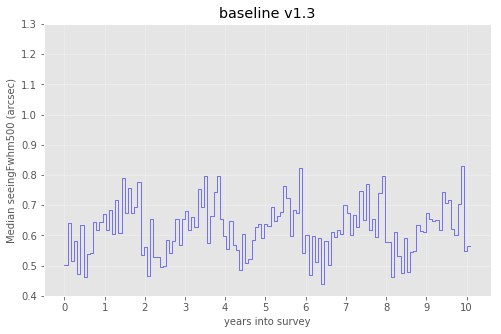

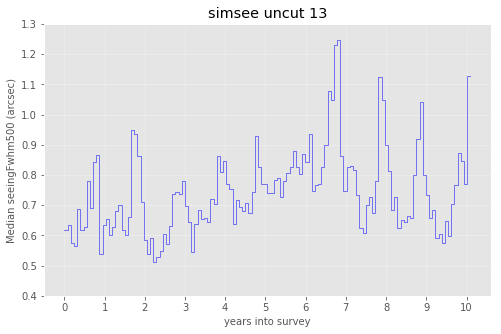

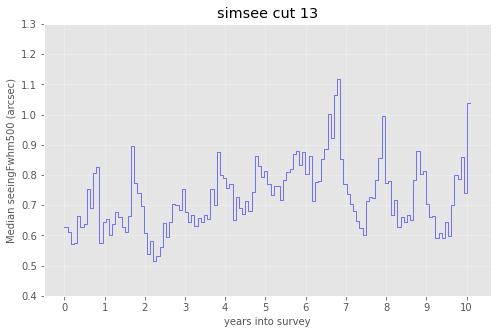

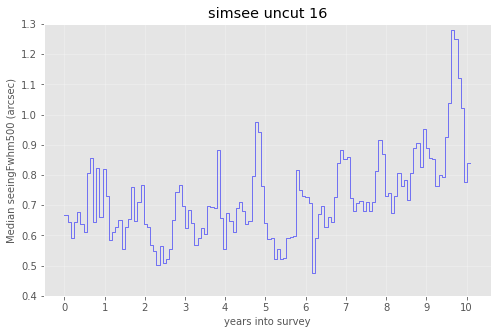

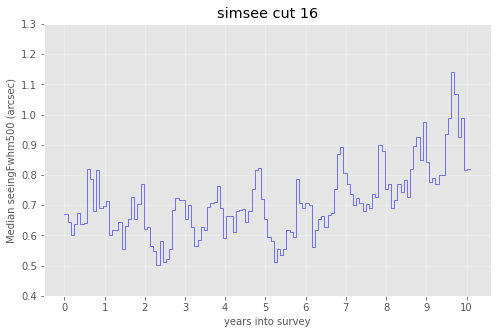

In [65]:
for sim in sims:
    sim_db_name = os.path.join(sim_db_path, sim.fname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, sim.fname)
    results_db = db.ResultsDb(outDir=results_path)

    seeing_metric = metrics.MedianMetric('seeingFwhm500')
    night_slicer = slicers.OneDSlicer('night')
    median_seeing = metricBundles.MetricBundle(seeing_metric, night_slicer)
    median_seeing_bundle = {'median_seeing': median_seeing}
    median_seeing_group = metricBundles.MetricBundleGroup(median_seeing_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    median_seeing_group.runAll()
    median_seeing_group.plotAll(closefigs=False)

    plt.ylim(0.4, 1.3)

    year_positions = np.arange(11)
    year_ticks = (np.floor(365.24*year_positions)).astype(int)
    year_labels = [str(p) for p in year_positions]
    plt.xticks(year_ticks, year_labels)
    plt.xlabel('years into survey')
    
    plt.title(sim.title)
    fig = plt.gcf()
    fig.savefig(os.path.join(note_dir, f'seeing_{sim.fname.replace(".", "_")}.png'), pdi=300, bbox_inches='tight')

## Map the seeing in the different simulations

In [84]:
def map_seeing(dbname,
               sql_constraint = 'filter = "i"',
               metric=metrics.MeanMetric):
    sql_contstraint = f'filter = "{band}"'
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('seeingFwhmEff')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'seeingFwhmEff': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()
    
    df = pd.DataFrame.from_records(metric_group.simData)
    summary_stats = df.seeingFwhmEff.describe()
    
    print(df.seeingFwhmEff.describe())
    
    map_plot = plots.spatialPlotters.HealpixSkyMap()
    map_plot.defaultPlotDict['colorMin'] = 0.75
    map_plot.defaultPlotDict['colorMax'] = 1.30
    if use_altaz:
        map_plot.defaultPlotDict['figsize'] = (5, 5.5)
        map_plot.healpy_visufunc = hp.azeqview
        map_plot.healpy_visufunc_params = {'rot': (0.01, -89.99, 0), 'reso': 18, 'lamb': True}
    
    metric_group.bundleDict['seeingFwhmEff'].setPlotFuncs([map_plot])
    metric_group.plotAll(closefigs=False)
    return (plt.gcf(), plt.gca(), summary_stats)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 470224 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470224.000000
mean          0.909407
std           0.214190
min           0.491085
25%           0.759148
50%           0.871685
75%           1.019213
max           3.367848
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "i"" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 470782 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470782.000000
mean          1.046175


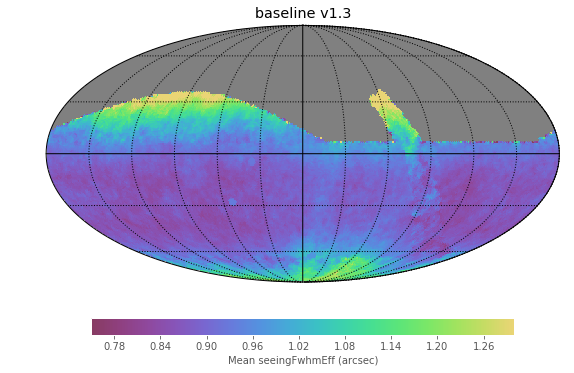

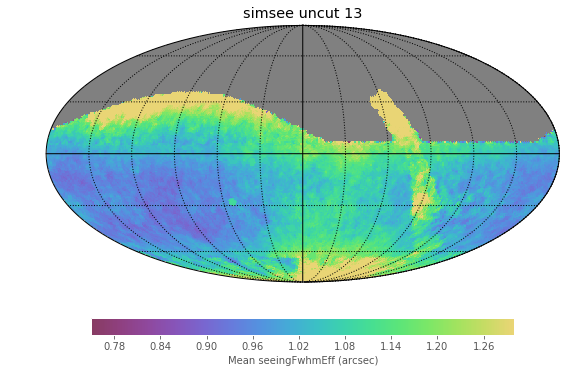

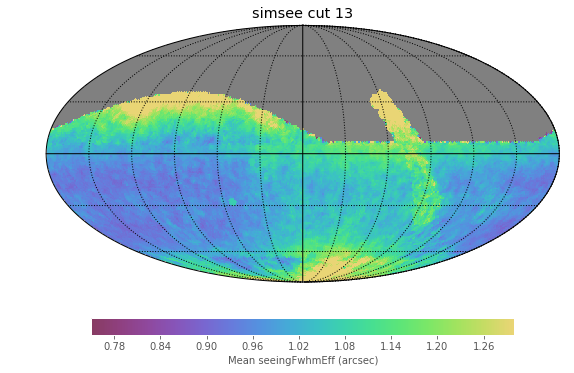

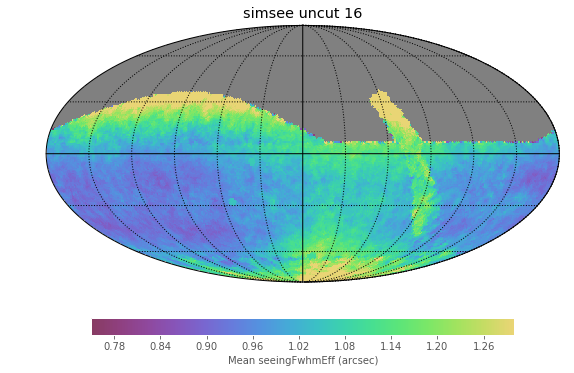

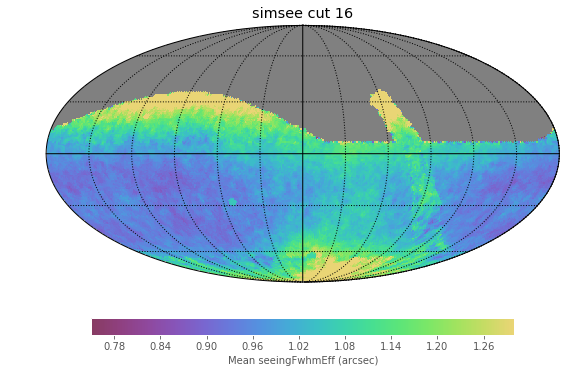

In [85]:
seeing_axes = {}
for sim in sims:
    fig, ax, summary_stats = map_seeing(sim.fname)
    ax.set_title(sim.title)
    fig.savefig(os.path.join(note_dir, f'seeing_map_{sim.fname.replace(".", "_")}.png'), pdi=300, bbox_inches='tight')

## Compare the depths of the different simulations

In [14]:
def map_depth(dbname,
              sql_constraint = 'filter = "i"',
              metric=metrics.MeanMetric,
             ):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    depth_metric = metric('fiveSigmaDepth')
    healpix_slicer = slicers.HealpixSlicer(nside=64)
    metric_bundle = {'depth': metricBundles.MetricBundle(depth_metric, healpix_slicer, sql_constraint)}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    
    metric_group.runAll()

    df = pd.DataFrame.from_records(metric_group.simData)
    print(df.fiveSigmaDepth.describe())

    map_plot = plots.spatialPlotters.HealpixSkyMap()
    map_plot.defaultPlotDict['colorMin'] = 23.1
    map_plot.defaultPlotDict['colorMax'] = 23.75
    if use_altaz:
        map_plot.defaultPlotDict['figsize'] = (5, 5.5)
        map_plot.healpy_visufunc = hp.azeqview
        map_plot.healpy_visufunc_params = {'rot': (0.01, -89.99, 0), 'reso': 18, 'lamb': True}

    metric_group.bundleDict['depth'].setPlotFuncs([map_plot])
    metric_group.plotAll(closefigs=False)
    return (plt.gcf(), plt.gca())

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 470224 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470224.000000
mean         23.512494
std           0.378289
min          21.387924
25%          23.285501
50%          23.565614
75%          23.787857
max          24.426921
Name: fiveSigmaDepth, dtype: float64
Plotting figures with "filter = "i"" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "i" for columns ['fiveSigmaDepth', 'fieldRA', 'fieldDec']
Found 470782 visits
Running:  ['depth']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    470782.000000
mean         23.395701
std          

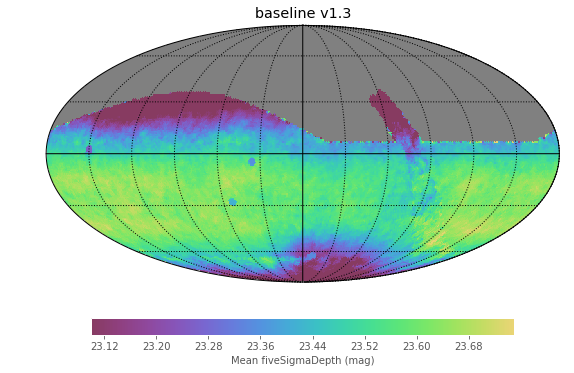

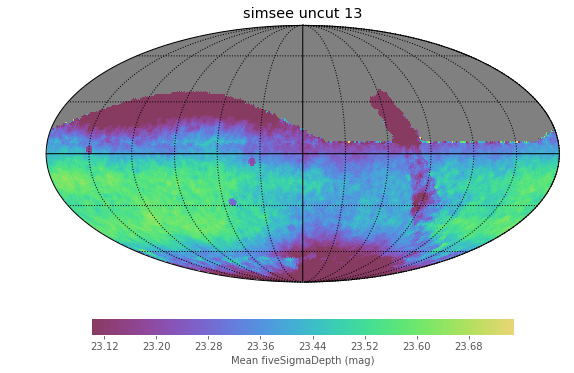

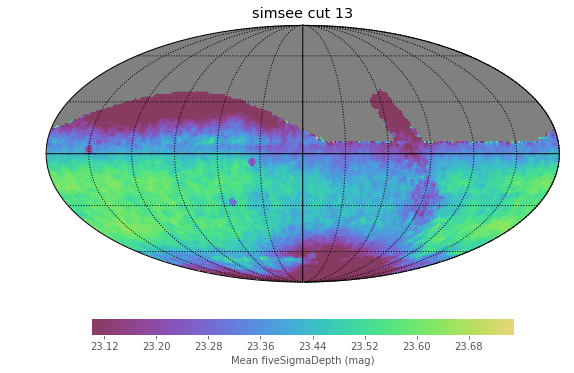

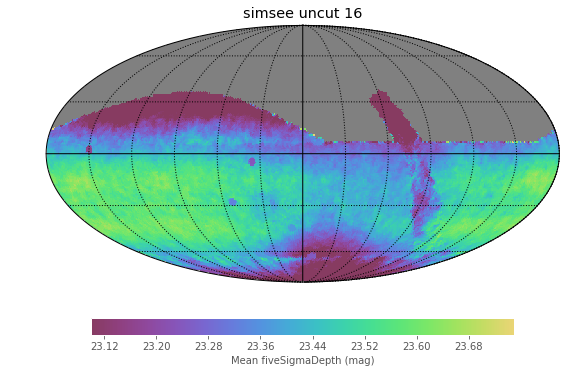

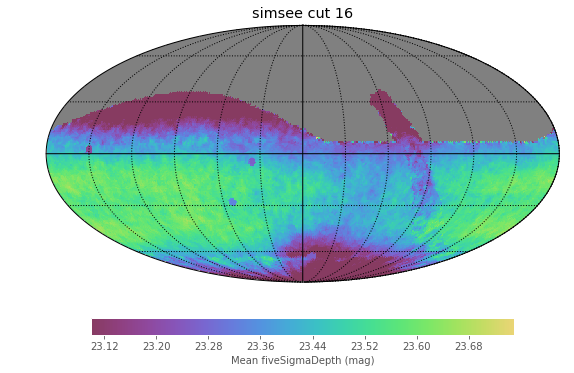

In [15]:
for sim in sims:
    fig, ax = map_depth(sim.fname)
    ax.set_title(sim.title)
    fig.savefig(os.path.join(note_dir, f'depth_map_{sim.fname.replace(".", "_")}.png'), pdi=300, bbox_inches='tight')

## Plotting depth and seeing with field R.A.

### Support code

Load data into `pandas.DataFrame`s.

In [109]:
def load_df(dbname,
            metric_columns = ['seeingFwhmEff', 'fiveSigmaDepth'],
            slice_column = 'fieldRA',
            sql_constraint = 'filter = "i" AND fieldDec<0 AND fieldDec>-60',
            agg_metric=metrics.MeanMetric):
    sim_db_name = os.path.join(sim_db_path, dbname) + os.extsep + 'db'
    sim_db = db.OpsimDatabase(sim_db_name)
    
    results_path = os.path.join(base_results_path, dbname)
    results_db = db.ResultsDb(outDir=results_path)

    slicer_for_df = slicers.OneDSlicer(slice_column)
    metric_bundle = {col: metricBundles.MetricBundle(agg_metric(col), slicer_for_df, sql_constraint)
                     for col in metric_columns}
    metric_group = metricBundles.MetricBundleGroup(metric_bundle, sim_db, outDir=results_path, resultsDb=results_db)
    metric_group.runAll()
    df = pd.DataFrame.from_records(metric_group.simData)
    df.sort_values('fieldRA', inplace=True)
    df['hour'] = np.floor(df.fieldRA/15).astype(np.int32)
    return df

### Load the data

In [110]:
see_by_ra = {s.title: load_df(s.fname) for s in sims}

Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 365707 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.373112 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 366157 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.373077 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 366318 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.373114 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 365918 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.373116 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "i" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fiveSigmaDepth', 'fieldRA']
Found 366267 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running:  ['fiveSigmaDepth']


/data/des91.b/data/neilsen/LSST/devel/sims_maf/python/lsst/sims/maf/slicers/oneDSlicer.py:74: UserWarning: Both binsize and bins have been set; Using binsize 5.373104 only.
  warnings.warn('Both binsize and bins have been set; Using binsize %f only.' %(self.binsize))


Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


### Plot depth against R.A.

Text(0.5, 1.0, 'fields with -60°<Decl<0°')

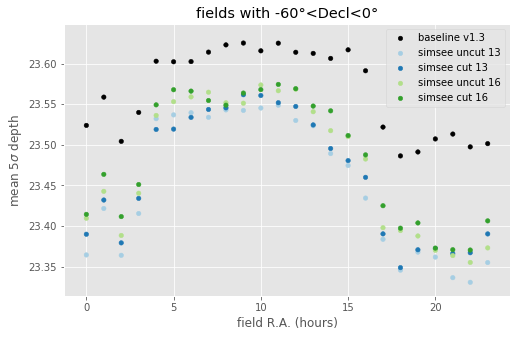

In [111]:
fig, axes = plt.subplots()
cmap = mpl.cm.get_cmap('Paired')
ncolor_in_map = 12
point_color = {sims[0].title: 'k'}
for sim_idx in np.arange(4):
    point_color[sims[sim_idx+1].title] = cmap((sim_idx+0.5)/(ncolor_in_map))
for sim in sims:
    df = see_by_ra[sim.title]
    label = sim.title
    color = [point_color[sim.title]]*24
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=color, label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean 5$\sigma$ depth')
axes.set_title(u"fields with -60\u00B0<Decl<0\u00B0")

### Plot delivered FWHM against R.A.

Text(0.5, 1.0, 'fields with -60°<Decl<0°')

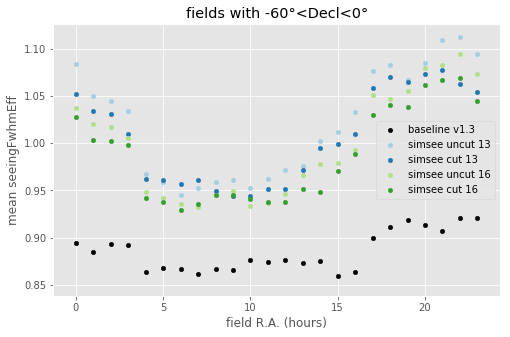

In [112]:
fig, axes = plt.subplots()
for sim in sims:
    df = see_by_ra[sim.title]
    label = sim.title
    color = point_color[sim.title]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=[color], label=label, ax=axes)
axes.set_xlabel('field R.A. (hours)')
axes.set_ylabel('mean seeingFwhmEff')
axes.set_title(u"fields with -60\u00B0<Decl<0\u00B0")

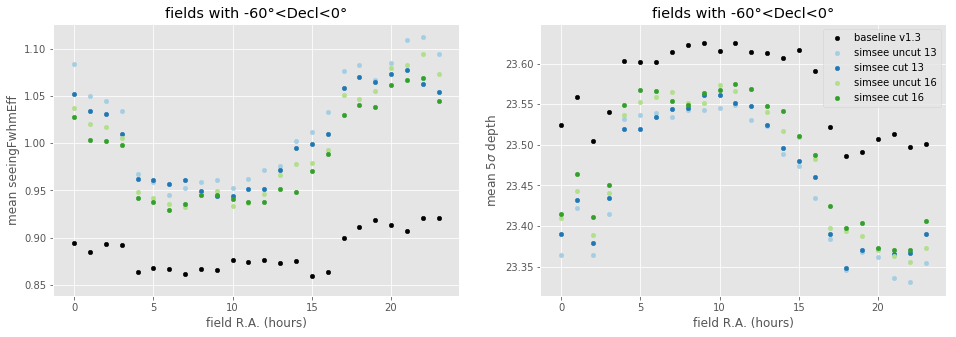

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for sim in sims:
    df = see_by_ra[sim.title]
    label = sim.title
    color = point_color[sim.title]
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'seeingFwhmEff', c=[color], label=label, ax=axes[0])
    df.groupby(df.hour).mean().reset_index().plot.scatter('hour', 'fiveSigmaDepth', c=[color], label=label, ax=axes[1])

axes[0].set_xlabel('field R.A. (hours)')
axes[0].set_ylabel('mean seeingFwhmEff')
axes[0].set_title(u"fields with -60\u00B0<Decl<0\u00B0")

axes[1].set_xlabel('field R.A. (hours)')
axes[1].set_ylabel('mean 5$\sigma$ depth')
axes[1].set_title(u"fields with -60\u00B0<Decl<0\u00B0")

axes[0].get_legend().remove()
fig.savefig(os.path.join(note_dir, 'seeing_depth_by_ra.png'), pdi=300, bbox_inches='tight')


In [114]:
see_by_ra[sim.title].head()

seeingFwhmEff  fiveSigmaDepth   fieldRA  hour
281966       1.042342       23.479239  0.001498     0
285451       1.643056       23.081881  0.002841     0
221140       0.833917       23.167643  0.004415     0
361158       0.817670       23.806753  0.005448     0
173746       0.962705       23.238248  0.006297     0

In [115]:
bl = see_by_ra[sims[0].title].groupby('hour')['seeingFwhmEff', 'fiveSigmaDepth'].mean()

cols = ['seeingFwhmEff', 'fiveSigmaDepth']
lims = {c: {'max': [], 'min': []} for c in cols}

for sim in sims[1:]:
    df = see_by_ra[sim.title].groupby('hour')[cols].mean()        
    for col in cols:
        difference = (df[col]-bl[col])/bl[col] if col=='seeingFwhmEff' else (bl[col]-df[col])
        lims[col]['max'].append(difference.max())
        lims[col]['min'].append(difference.min())
        
result = pd.DataFrame({}, index=[s.title for s in sims[1:]])
for col in cols:
    for s in 'min', 'max':
        result['_'.join((s, col))] = lims[col][s]
result.sort_index()

min_seeingFwhmEff  max_seeingFwhmEff  min_fiveSigmaDepth  \
simsee cut 13             0.077666           0.187087            0.054959   
simsee cut 16             0.070879           0.175883            0.034408   
simsee uncut 13           0.087030           0.222285            0.062915   
simsee uncut 16           0.066262           0.193831            0.042021   

                 max_fiveSigmaDepth  
simsee cut 13              0.147083  
simsee cut 16              0.142322  
simsee uncut 13            0.176723  
simsee uncut 16            0.149529

In [116]:
cols = ['seeingFwhmEff', 'fiveSigmaDepth']
lims = {c: [] for c in cols}

for sim in sims:
    df = see_by_ra[sim.title].groupby('hour')[cols].mean()        
    for col in cols:
        mean_value = df[col].mean()
        difference = (df[col]-mean_value)/mean_value if col=='seeingFwhmEff' else (mean_value-df[col])
        lims[col].append(difference.rolling(window=6).mean().max()-difference.rolling(window=6).mean().min())
        
result = pd.DataFrame({}, index=[s.title for s in sims])
for col in cols:
        result[col] = lims[col]
result.sort_index()

seeingFwhmEff  fiveSigmaDepth
baseline v1.3         0.056427        0.119995
simsee cut 13         0.116995        0.182450
simsee cut 16         0.115944        0.176033
simsee uncut 13       0.134405        0.192450
simsee uncut 16       0.133561        0.188627

## Map all filters

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "u" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 139641 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    139641.000000
mean          1.065173
std           0.274703
min           0.515543
25%           0.865000
50%           1.023396
75%           1.215667
max           2.808864
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "u"" constraint now.
Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "u" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 139445 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    139445.000000
mean          1.241628


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "z" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 461305 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    461305.000000
mean          1.026243
std           0.315070
min           0.475151
25%           0.814889
50%           0.954643
75%           1.154855
max           5.615579
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "z"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "z" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 460992 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    460992.000000
mean          1.007168
std           0.285063
min           0.506126
25%           0.813091
50%           0.947673
75%           1.129181
max           4.952182
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "z"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "z" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 462011 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    462011.000000
mean          1.000546
std           0.298579
min           0.485765
25%           0.799790
50%           0.935340
75%           1.122516
max           4.571426
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "z"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "z" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 461998 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    461998.000000
mean          0.990796
std           0.280349
min           0.480137
25%           0.798619
50%           0.931869
75%           1.114167
max           4.186765
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "z"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "y" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 421734 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    421734.000000
mean          0.873074
std           0.192037
min           0.488293
25%           0.736788
50%           0.838926
75%           0.971648
max           3.281466
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "y"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "y" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 422239 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    422239.000000
mean          1.002764
std           0.300538
min           0.472371
25%           0.798804
50%           0.933707
75%           1.128276
max           5.805456
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "y"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "y" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 422142 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    422142.000000
mean          0.992288
std           0.294108
min           0.481687
25%           0.793954
50%           0.928482
75%           1.116328
max           4.693475
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "y"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "y" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 421993 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    421993.000000
mean          0.983166
std           0.293234
min           0.472610
25%           0.788153
50%           0.917781
75%           1.100324
max           4.450553
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "y"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter = "y" for columns ['seeingFwhmEff', 'fieldRA', 'fieldDec']
Found 422103 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
count    422103.000000
mean          0.981019
std           0.284773
min           0.493584
25%           0.790353
50%           0.918956
75%           1.096386
max           3.979695
Name: seeingFwhmEff, dtype: float64
Plotting figures with "filter = "y"" constraint now.


/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2019_37/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Plotting complete.


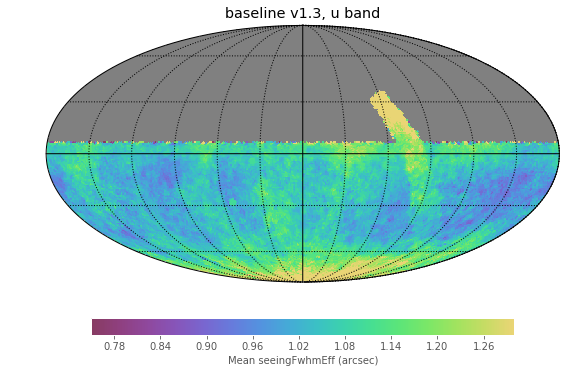

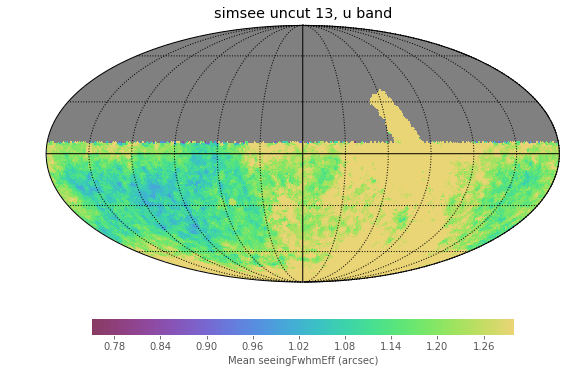

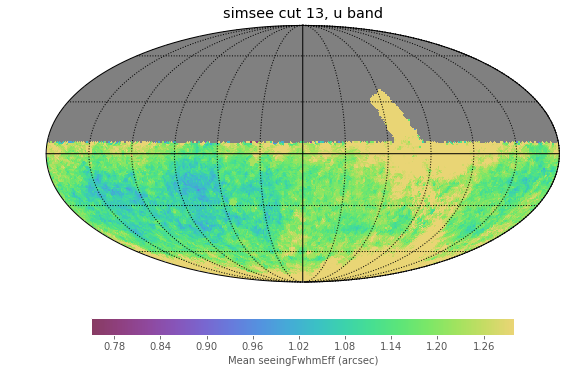

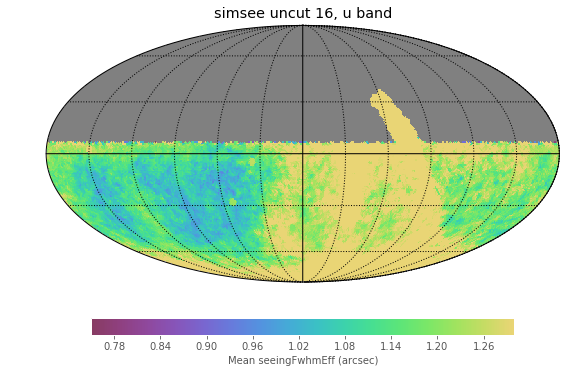

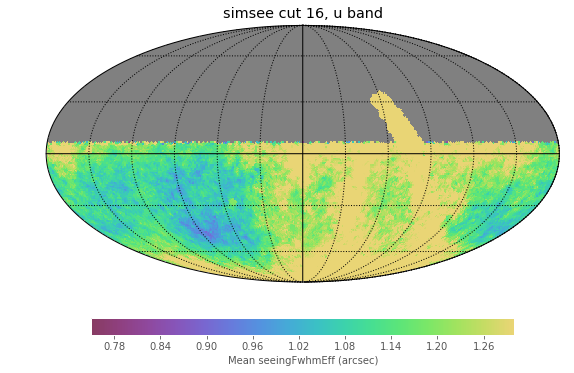

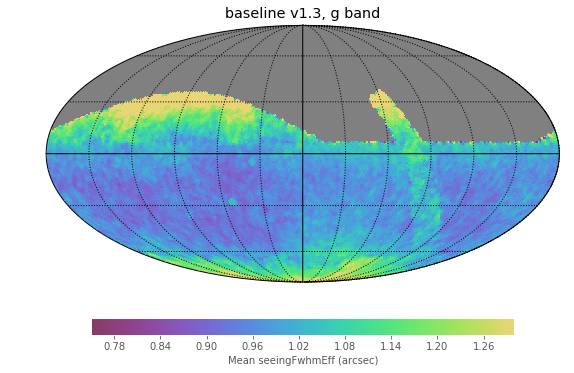

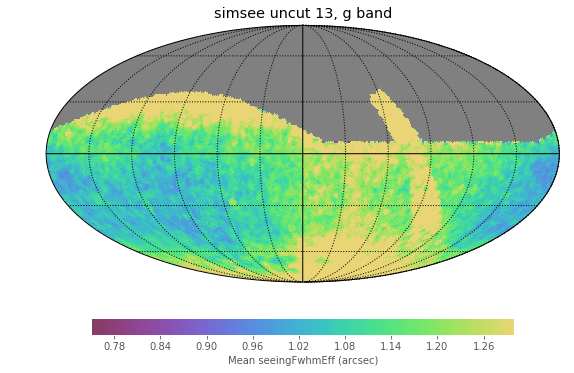

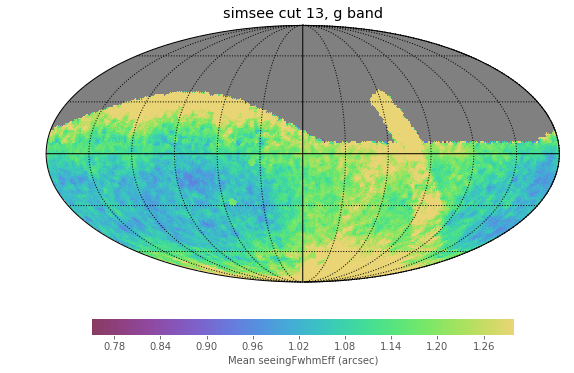

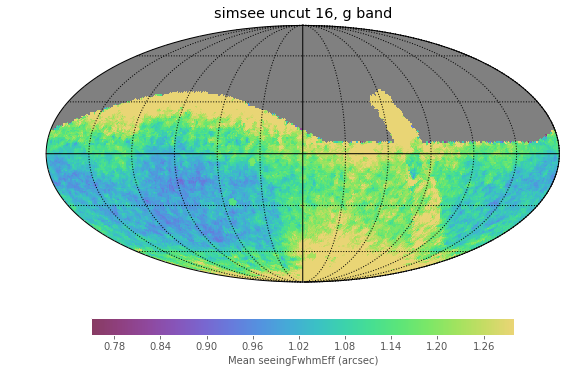

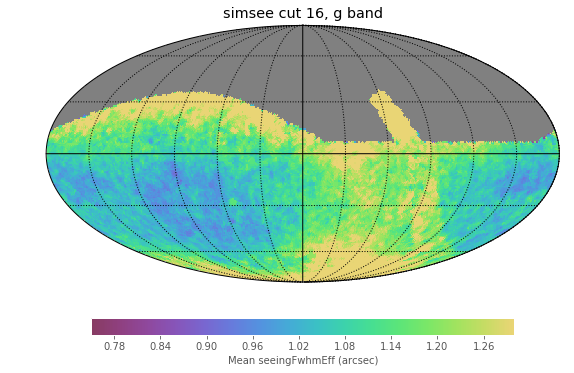

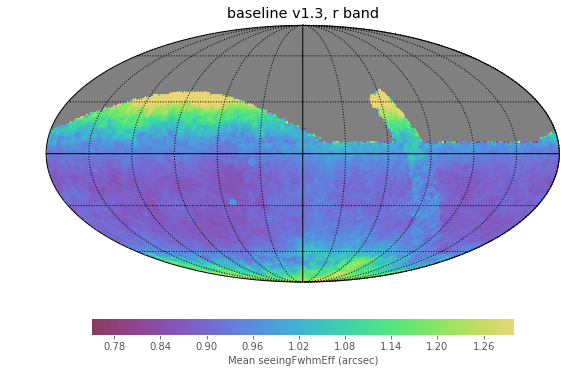

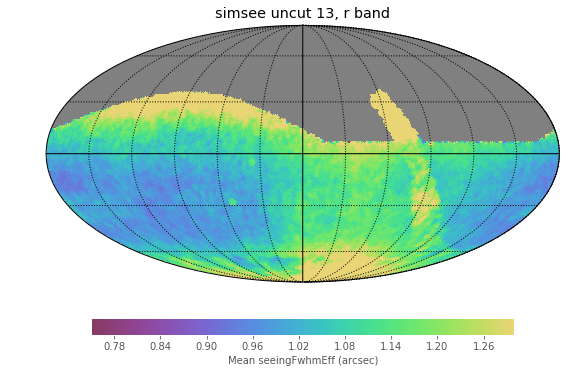

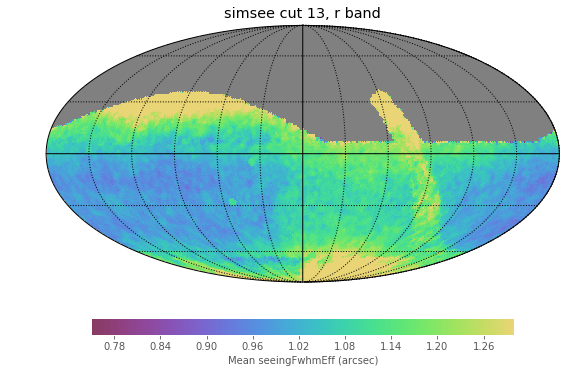

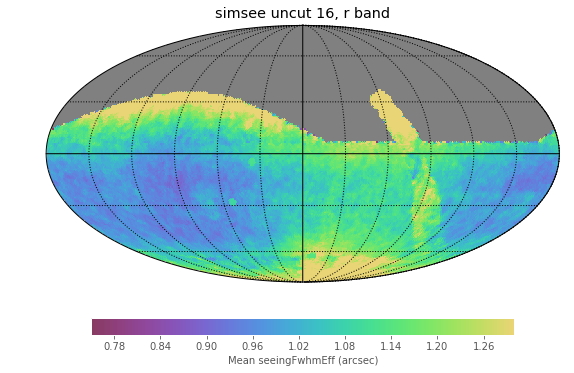

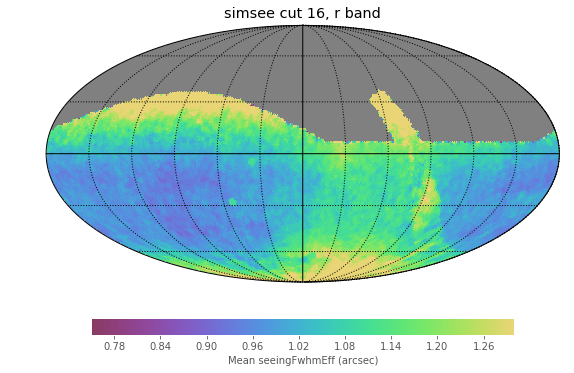

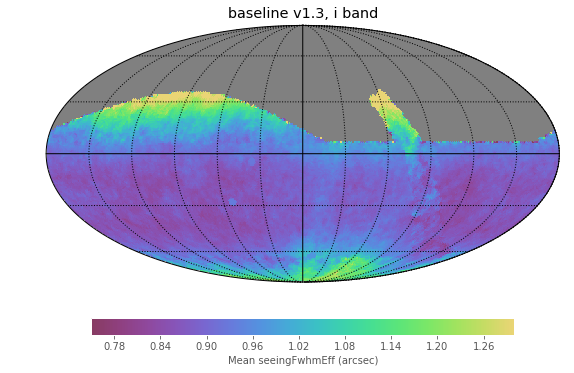

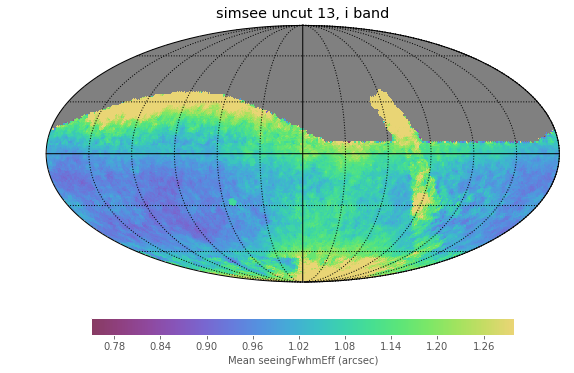

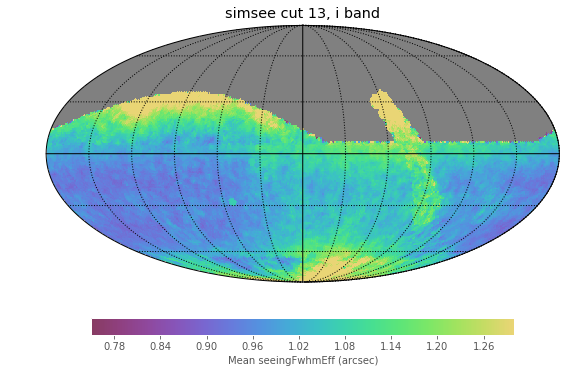

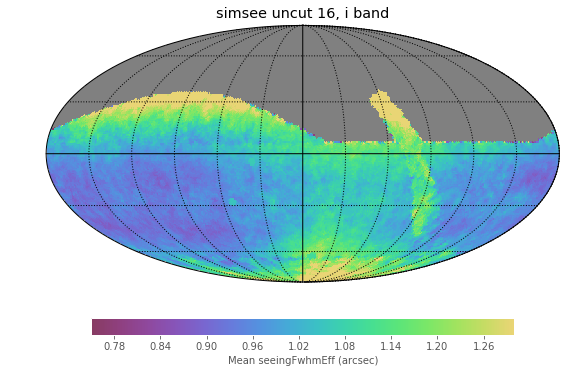

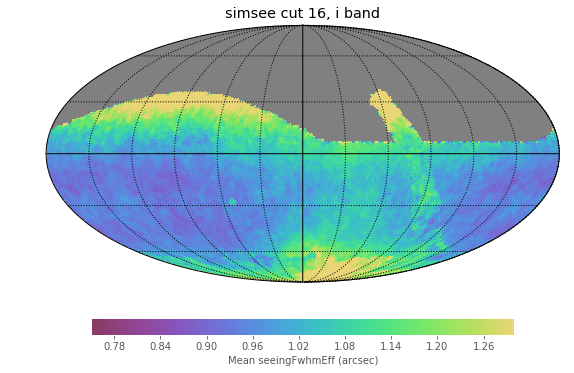

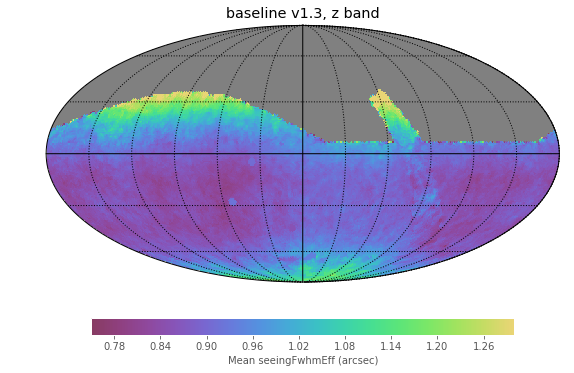

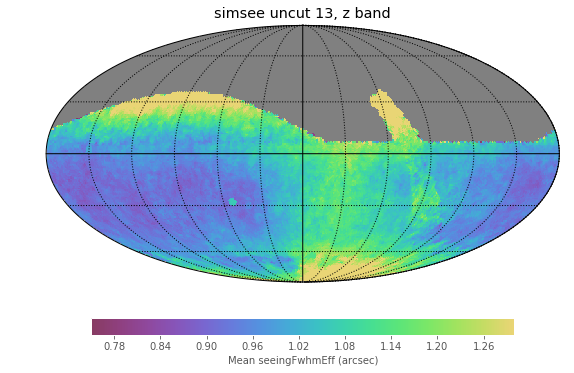

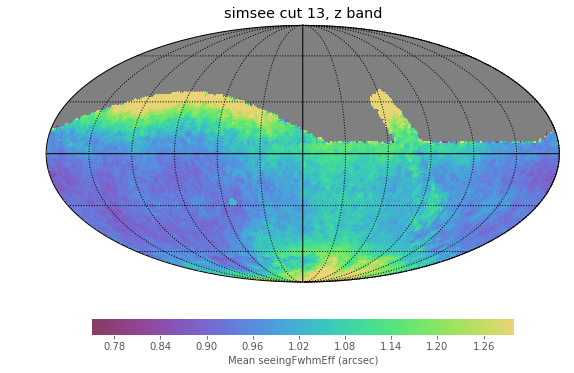

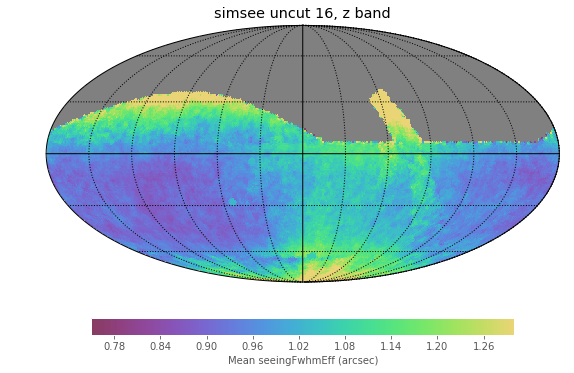

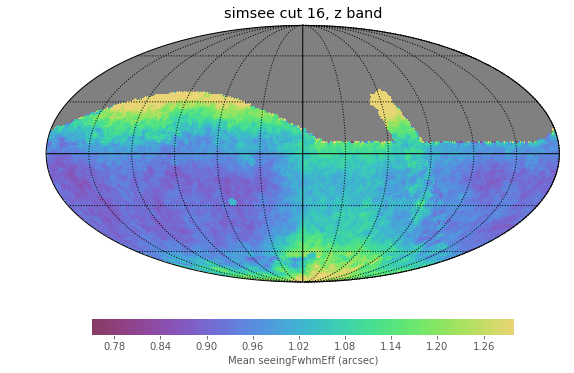

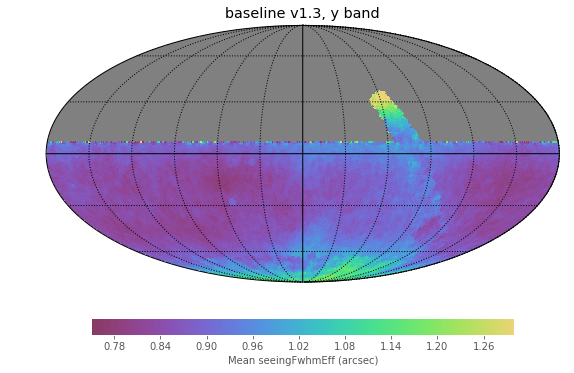

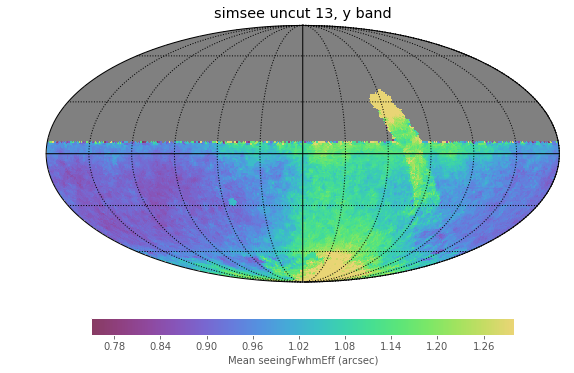

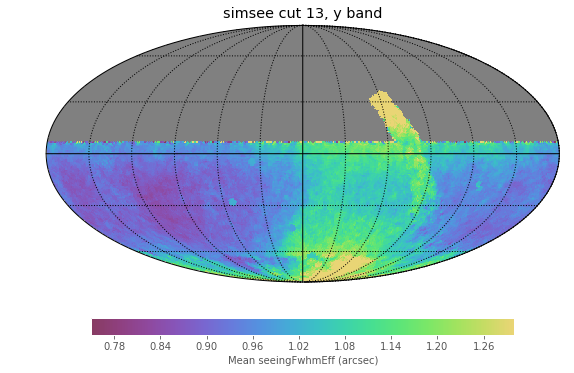

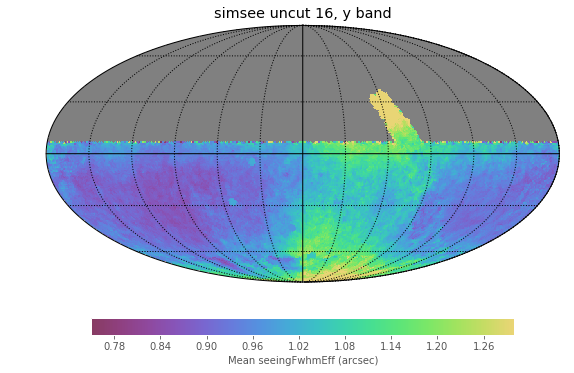

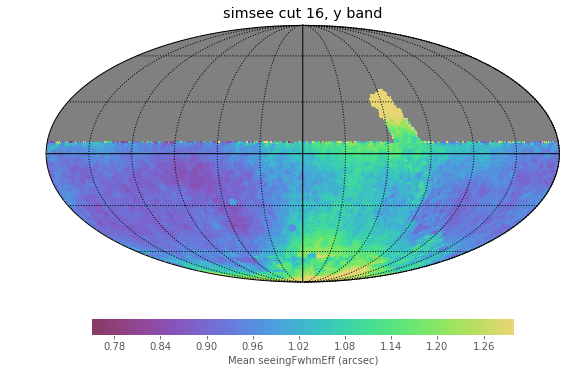

In [140]:
stats_df = pd.DataFrame()
for band in ('u', 'g', 'r', 'i', 'z', 'y'):
    for sim in sims:
        fig, ax, sim_stats = map_seeing(sim.fname, sql_constraint = f'filter = "{band}"')
        sim_stats.name = sim.title
        sim_stats['band'] = band
        stats_df = stats_df.append(sim_stats)
        ax.set_title(sim.title + ", " + band + " band")
        fig.savefig(os.path.join(note_dir, f'depth_map_{sim.fname.replace(".", "_")}_{band}.png'), pdi=300, bbox_inches='tight')

In [141]:
df = stats_df.copy()
df['IQR'] = df['75%'] - df['25%']
df.index.name = 'simulation'
df = df.reset_index().pivot(index='simulation', columns='band', values=['mean', 'IQR'])
df

mean                                                    \
band                    g         i         r         u         y         z   
simulation                                                                    
baseline v1.3    0.997031  0.909407  0.938687  1.065173  0.873074  0.896670   
simsee cut 13    1.141738  1.028883  1.070641  1.199118  0.992288  1.007168   
simsee cut 16    1.127144  1.013290  1.054360  1.214583  0.981019  0.990796   
simsee uncut 13  1.160579  1.046175  1.085367  1.241628  1.002764  1.026243   
simsee uncut 16  1.134726  1.021270  1.061536  1.226014  0.983166  1.000546   

                      IQR                                                    
band                    g         i         r         u         y         z  
simulation                                                                   
baseline v1.3    0.307311  0.260064  0.278349  0.350668  0.234860  0.248494  
simsee cut 13    0.391610  0.329696  0.352350  0.411514  0.322374  0.316090  
simsee cut 16    0.390842  0.334253  0.356259  0.429521  0.306033  0.315548  
simsee uncut 13  0.401691  0.343155  0.365144  0.437714  0.329471  0.339966  
simsee uncut 16  0.406446  0.339448  0.367099  0.426429  0.312171  0.322726

In [142]:
with pd.option_context('precision', 2):
    print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} & \multicolumn{6}{l}{mean} & \multicolumn{6}{l}{IQR} \\
band &     g &     i &     r &     u &     y &     z &     g &     i &     r &     u &     y &     z \\
simulation      &       &       &       &       &       &       &       &       &       &       &       &       \\
\midrule
baseline v1.3   &  1.00 &  0.91 &  0.94 &  1.07 &  0.87 &  0.90 &  0.31 &  0.26 &  0.28 &  0.35 &  0.23 &  0.25 \\
simsee cut 13   &  1.14 &  1.03 &  1.07 &  1.20 &  0.99 &  1.01 &  0.39 &  0.33 &  0.35 &  0.41 &  0.32 &  0.32 \\
simsee cut 16   &  1.13 &  1.01 &  1.05 &  1.21 &  0.98 &  0.99 &  0.39 &  0.33 &  0.36 &  0.43 &  0.31 &  0.32 \\
simsee uncut 13 &  1.16 &  1.05 &  1.09 &  1.24 &  1.00 &  1.03 &  0.40 &  0.34 &  0.37 &  0.44 &  0.33 &  0.34 \\
simsee uncut 16 &  1.13 &  1.02 &  1.06 &  1.23 &  0.98 &  1.00 &  0.41 &  0.34 &  0.37 &  0.43 &  0.31 &  0.32 \\
\bottomrule
\end{tabular}



In [130]:
mean_seeing_by_hr_stats = []
for band in ('u', 'g', 'r', 'i', 'z', 'y'):
    for sim in sims:
        df = load_df(sim.fname,
                     metric_columns = ['seeingFwhmEff'],
                     sql_constraint = f'filter = "{band}" AND fieldDec<0 AND fieldDec>-60')
        s = df.groupby(df.hour).mean()['seeingFwhmEff'].describe()
        s.name = sim.title + "_" + band
        s['simulation'] = sim.title
        s['band'] = band
        mean_seeing_by_hr_stats.append(s)


Querying database SummaryAllProps with constraint filter = "u" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fieldRA']
Found 112702 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "u" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fieldRA']
Found 112451 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "u" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fieldRA']
Found 112242 visits
Running:  ['seeingFwhmEff']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter = "u" AND fieldDec<0 AND fieldDec>-60 for columns ['seeingFwhmEff', 'fieldRA']
Found 112051 visits
Running:  ['seei

In [136]:
df = pd.DataFrame(mean_seeing_by_hr_stats)
df['IQR'] = df['75%'] - df['25%']
df = df.pivot(index='simulation', columns='band', values=['mean', 'IQR'])
df

mean                                                    \
band                    g         i         r         u         y         z   
simulation                                                                    
baseline v1.3    0.968773  0.885145  0.912752  1.042447  0.862567  0.873889   
simsee cut 13    1.114789  1.005965  1.045067  1.175225  0.979036  0.983503   
simsee cut 16    1.099864  0.987209  1.029363  1.188425  0.969649  0.968123   
simsee uncut 13  1.134449  1.020452  1.059147  1.217437  0.989405  1.002790   
simsee uncut 16  1.105286  0.997792  1.036626  1.197252  0.970182  0.977420   

                      IQR                                                    
band                    g         i         r         u         y         z  
simulation                                                                   
baseline v1.3    0.033794  0.034271  0.037026  0.044448  0.056743  0.041383  
simsee cut 13    0.137011  0.094876  0.116968  0.067515  0.121500  0.095406  
simsee cut 16    0.126780  0.090660  0.109915  0.148452  0.096322  0.086549  
simsee uncut 13  0.165604  0.116341  0.131457  0.148724  0.148249  0.125291  
simsee uncut 16  0.146370  0.102310  0.126329  0.163474  0.095616  0.108497

In [137]:
with pd.option_context('precision', 2):
    print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
{} & \multicolumn{6}{l}{mean} & \multicolumn{6}{l}{IQR} \\
band &     g &     i &     r &     u &     y &     z &     g &     i &     r &     u &     y &     z \\
simulation      &       &       &       &       &       &       &       &       &       &       &       &       \\
\midrule
baseline v1.3   &  0.97 &  0.89 &  0.91 &  1.04 &  0.86 &  0.87 &  0.03 &  0.03 &  0.04 &  0.04 &  0.06 &  0.04 \\
simsee cut 13   &  1.11 &  1.01 &  1.05 &  1.18 &  0.98 &  0.98 &  0.14 &  0.09 &  0.12 &  0.07 &  0.12 &  0.10 \\
simsee cut 16   &  1.10 &  0.99 &  1.03 &  1.19 &  0.97 &  0.97 &  0.13 &  0.09 &  0.11 &  0.15 &  0.10 &  0.09 \\
simsee uncut 13 &  1.13 &  1.02 &  1.06 &  1.22 &  0.99 &  1.00 &  0.17 &  0.12 &  0.13 &  0.15 &  0.15 &  0.13 \\
simsee uncut 16 &  1.11 &  1.00 &  1.04 &  1.20 &  0.97 &  0.98 &  0.15 &  0.10 &  0.13 &  0.16 &  0.10 &  0.11 \\
\bottomrule
\end{tabular}

